# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `36`
* Students: `Muller Christophe, Bernard-Michel Martial, Coullery Ludovic, Faraut Victor`
* Dataset: `Free music archive`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [1]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

In [2]:
adjacency = np.load('../Milestone_1/adjacency.npy')
n_nodes = np.size(adjacency,1) # the number of nodes in the network
n_edges = sum(sum(adjacency!=0))/2 # number of edges in the network
degrees = sum(adjacency!=0)

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

In [3]:
#D = scipy.sparse.spdiags(degrees, [0], n_nodes, n_nodes, format='csr')
#W = adjacency
#L = D-W
#Dsqrt = scipy.sparse.spdiags(1/scipy.sqrt(degrees), [0], n_nodes, n_nodes, format='csr')

In [4]:
D = scipy.sparse.spdiags(degrees, [0], n_nodes, n_nodes, format='csr')
sW = scipy.sparse.csr_matrix(adjacency)
L = D-sW

Dsqrt = scipy.sparse.spdiags(1/scipy.sqrt(degrees), [0], n_nodes, n_nodes, format='csr')

In [5]:
laplacian_combinatorial =  L
laplacian_normalized =  Dsqrt.dot(L.dot(Dsqrt))

SyntaxError: invalid syntax (<ipython-input-4-8220c409e189>, line 1)

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [6]:
laplacian =  laplacian_normalized

SyntaxError: invalid syntax (<ipython-input-5-31c0b7cf789e>, line 1)

### Question 2

Compute the eigendecomposition of the Laplacian $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [7]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(laplacian, k=n_nodes-1)
eigenvalues = np.append([0], eigenvalues)
first_eigvect = np.ones([n_nodes, 1])/n_nodes
eig_temp = np.append(first_eigvect, eigenvectors, axis=1)
eigenvectors = eig_temp.T
assert eigenvectors.shape == (n_nodes, n_nodes)

SyntaxError: invalid syntax (<ipython-input-6-b06839044a1b>, line 1)

In [13]:
#idem for combinatorial laplacian:
eigenvalues_comb, eigenvectors_comb = scipy.sparse.linalg.eigsh(laplacian_combinatorial, k=n_nodes-1)
eigenvalues_comb = np.append([0], eigenvalues_comb)
#first_eigvect = np.ones([n_nodes, 1])/n_nodes
eig_temp = np.append(first_eigvect, eigenvectors_comb, axis=1)
eigenvectors_comb = eig_temp.T
assert eigenvectors_comb.shape == (n_nodes, n_nodes)

Justify your choice of eigensolver.

We used the `scipy.sparse.linalg.eigsh` method to compute `n_nodes-1` eigenvalues and -vectors since we have a sparse symmetric laplacian matrix. We added manually the trivial 0 eigenvalue and its corresponding vector of ones (normalized).

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

$S$ is the incidence matrix. Its dimensions are `n_nodes * n_edges` and for each node $n$ it takes the value 1 if the node has the edge $m$ linked to him and 0 if not. In the case of a directed graph (not our case) the values are $\pm$1 depending if the link goes in or out of the node.

$S^Tx$ for a given $x \in \mathbb{R}^N$ gives us the gradient of $x$, $S^Tx [i]$ returns the derivative of vector $x$ along the edge $[i]$.

### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

**TO DO**

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**

**TO DO**

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

It is a unit vector normalized according to the size of the graph.

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

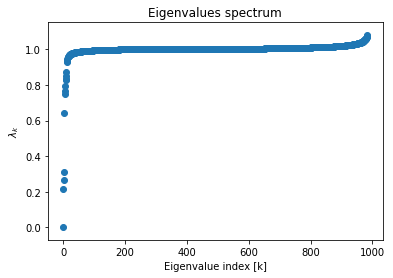

In [11]:
plt.scatter(range(n_nodes), eigenvalues)
plt.xlabel('Eigenvalue index [k]')
plt.ylabel('$\lambda_k$')
plt.title('Eigenvalues spectrum')
plt.show()

We have a small group of small eigenvalues near 0, then a bigger group around 0.8 and finally most of the eigenvalues are more or less equal to 1.

How many connected components are there in your graph? Answer using the eigenvalues only.

In [8]:
eigenvalues[:5]

array([0.        , 0.21803218, 0.26418045, 0.31185977, 0.64540397])

Considering the eigenvalues close to zero, we estimate the number of connected components to 4 since after the fourth eigenvalues start to increase much more rapidly.

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

In [19]:
print('Max eigenvalue for normalized laplacian:',max(eigenvalues),
      '\nMax eigenvalue for combinatorial laplacian:', max(eigenvalues_comb))

Max eigenvalue for normalized laplacian: 1.0827295807910167 
Max eigenvalue for combinatorial laplacian: 603.8733422735547


**Your answer here.**

**TO DO and understand**

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

To reduce the dimensionality of our graph, reduce computational cost of further calculations and more easily perform clustering on our dataset.

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [ ]:
# Your code here.

Plot the nodes embedded in 2D. Comment on what you see.

In [ ]:
# Your code here.

**Your answer here.**

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Your answer here.**

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [ ]:
# Your code here.

### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [ ]:
# Your code here.

**Your answer here.**

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [ ]:
# Your code here.

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [ ]:
# Your code here.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Your answer here.**